In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
#tqdm for the progress bar
from tqdm import tqdm
print("All modules imported successfully.")

All modules imported successfully.


All of the files can be found on Kaggle.

https://www.kaggle.com/c/digit-recognizer/data

In [2]:
#load in data from kaggle
train_amt=37000

train_X=pd.read_csv("~/Downloads/train.csv")
#randomly shuffle it before splitting it into training and validation sets
#np.random.shuffle(train_X)

validation_X=train_X.loc[train_amt:]
train_X=train_X.loc[:train_amt-1]
train_y=train_X['label']
validation_y=validation_X['label']
del train_X['label']
del validation_X['label']
test_X=pd.read_csv("~/Downloads/test.csv")

In [3]:
#convert to numpy arrays and normalize values between 0 and 1
#normalizing allows the network to train better and converge faster
train_X=np.array(train_X)/255
train_y=np.array(train_y)
validation_X=np.array(validation_X)/255
validation_y=np.array(validation_y)
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape)
#test data
test_X=np.array(test_X).astype(dtype='float32')/255

(37000, 784) (37000,) (5000, 784) (5000,) (28000, 784)


In [4]:
train_X=train_X.reshape([-1, 28, 28, 1])
validation_X=validation_X.reshape([-1, 28, 28, 1])
test_X=test_X.reshape([-1, 28, 28, 1])
print(train_X.shape, validation_X.shape, test_X.shape)

(37000, 28, 28, 1) (5000, 28, 28, 1) (28000, 28, 28, 1)


In [5]:
#convert to one-hot array
train_y=np.array(pd.get_dummies(train_y))
validation_y=np.array(pd.get_dummies(validation_y))
print(train_y.shape, validation_y.shape)

(37000, 10) (5000, 10)


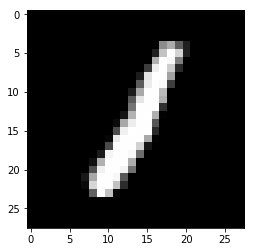

In [6]:
#show random number
test_img=train_X[np.random.randint(0,train_amt-1)].reshape(28,28)

plt.imshow(test_img, cmap='gray')
plt.show()

In [7]:
#make sure everything is a float32
tf.cast(train_X, tf.float32)
tf.cast(train_y, tf.float32)
tf.cast(validation_X, tf.float32)
tf.cast(validation_y, tf.float32)

<tf.Tensor 'Cast_3:0' shape=(5000, 10) dtype=float32>

In [8]:
#conv format=height, width, filters
#max pool format=side length
conv_layer1=[3,3,32]
conv_layer2=[3,3,64]
max_pool1=2
conv_layer3=[3,3,128]
conv_layer4=[3,3,256]
max_pool2=2
#output=7x7
nodes_fc1=1000
nodes_output=10

batch_size=128
num_epochs=30

In [9]:
regularizer=tf.contrib.layers.l2_regularizer(scale=0.002)

weights_conv_layer1=tf.get_variable('conv_weights_layer_1', dtype=tf.float32, 
                            initializer=tf.truncated_normal([conv_layer1[0], conv_layer1[1], 1, conv_layer1[2]], dtype=tf.float32, stddev=0.2),
                                   regularizer=regularizer)
biases_conv_layer1=tf.get_variable('conv_biases_layer_1', dtype=tf.float32, initializer= tf.zeros([conv_layer1[2]]))

weights_conv_layer2=tf.get_variable('conv_weights_layer_2', dtype=tf.float32, 
                            initializer=tf.truncated_normal([conv_layer2[0], conv_layer2[1], conv_layer1[2], conv_layer2[2]], dtype=tf.float32, stddev=0.2),
                                   regularizer=regularizer)

biases_conv_layer2=tf.get_variable('conv_biases_layer_2', dtype=tf.float32, initializer= tf.zeros([conv_layer2[2]]))

weights_conv_layer3=tf.get_variable('conv_weights_layer_3', dtype=tf.float32, 
                            initializer=tf.truncated_normal([conv_layer3[0], conv_layer3[1], conv_layer2[2], conv_layer3[2]], dtype=tf.float32, stddev=0.2),
                                   regularizer=regularizer)
biases_conv_layer3=tf.get_variable('conv_biases_layer_3', dtype=tf.float32, initializer= tf.zeros([conv_layer3[2]]))

weights_conv_layer4=tf.get_variable('conv_weights_layer_4', dtype=tf.float32, 
                            initializer=tf.truncated_normal([conv_layer4[0], conv_layer4[1], conv_layer3[2], conv_layer4[2]], dtype=tf.float32, stddev=0.2),
                                   regularizer=regularizer)
biases_conv_layer4=tf.get_variable('conv_biases_layer_4', dtype=tf.float32, initializer= tf.zeros([conv_layer4[2]]))

weights_fc1=tf.get_variable('weights_fc1', dtype=tf.float32, 
                            initializer=tf.truncated_normal([49*conv_layer4[2], nodes_fc1], dtype=tf.float32, stddev=np.sqrt(2/nodes_fc1)),
                           regularizer=regularizer)
biases_fc1=tf.get_variable('biases_fc1', dtype=tf.float32, initializer=tf.zeros([nodes_fc1]))

weights_output=tf.get_variable('weights_output', dtype=tf.float32, 
                               initializer=tf.truncated_normal([nodes_fc1, nodes_output], dtype=tf.float32, stddev=np.sqrt(2/nodes_output)),
                              regularizer=regularizer)

In [10]:
def conv_layer(layer_input, layer_weights, layer_biases, strides=1):
    conv_layer=tf.nn.conv2d(layer_input, layer_weights, [1, strides, strides, 1], 'SAME')
    conv_layer=tf.nn.bias_add(conv_layer, layer_biases)
    conv_layer=tf.nn.elu(conv_layer)
    return conv_layer

In [11]:
def max_pool(layer, width):
    return tf.nn.max_pool(value=layer, ksize=[1, width, width, 1], strides=[1, width, width, 1], padding='VALID')

In [12]:
#setting up placeholders where data will be passed into  later
features=tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
labels=tf.placeholder(tf.float32)

In [13]:
#create saver, max_to_keep is maximum checkpoint files kept
saver=tf.train.Saver(max_to_keep=1)

In [14]:
train=True

def forward_pass(x, train):
    #train is a bool
    #set conv keep to a number if train is true, else set it to 1
    conv_keep=train*0.8+(not train)*1
    fc_keep=train*0.7+(not train)*1
    
    conv_layer1=conv_layer(x, weights_conv_layer1, biases_conv_layer1)
    conv_layer1=tf.nn.dropout(conv_layer1, conv_keep)
    
    conv_layer2=conv_layer(conv_layer1, weights_conv_layer2, biases_conv_layer2)
    conv_layer2=tf.nn.dropout(conv_layer2, conv_keep)
    
    max_pool_1=max_pool(conv_layer2, max_pool1)
    
    conv_layer3=conv_layer(max_pool_1, weights_conv_layer3, biases_conv_layer3)
    conv_layer3=tf.nn.dropout(conv_layer3, conv_keep)
    
    conv_layer4=conv_layer(conv_layer3, weights_conv_layer4, biases_conv_layer4)
    conv_layer4=tf.nn.dropout(conv_layer4, conv_keep)
    
    max_pool_2=max_pool(conv_layer4, max_pool2)
    
    fc_input=tf.contrib.layers.flatten(max_pool_2)
    
    fc1=tf.add(tf.matmul(fc_input, weights_fc1), biases_fc1)
    fc1=tf.nn.dropout(fc1, fc_keep)
    
    logits=tf.matmul(fc1, weights_output)
    return logits

In [15]:
#cost and gradient descent
#tf.reduce_mean=np.mean and tf.reduce_sum=np.sum
lr=1e-3
learning_rate=tf.placeholder(tf.float32, shape=[])

logits=forward_pass(features,train)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#accuracy
#argmax takes the maximum value in each vector and sets it to 1, all others are set to 0
output=tf.nn.softmax(logits)
accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output, 1), tf.argmax(labels, 1)),tf.float32))

#used later for predicting the test data
prediction=tf.argmax(tf.nn.softmax(logits=output), 1)

In [16]:
import time
before_time=time.time()

with tf.Session() as sess:
    #initialize variables
    sess.run(tf.global_variables_initializer())
    #restore weights if file found
    try:
        saver.restore(sess, "/tmp/model.ckpt")
        print("Model restored.")
    except:
        print("No save file found.")

    
    batch_count = int(math.ceil(len(train_X)/batch_size))
    val_batches= int(math.ceil(len(validation_X)/1000))
    best_val_acc=0
    last_improve_epoch=0
    for epoch in range(num_epochs):
        #shuffle data
        state=np.random.get_state()
        np.random.shuffle(train_X)
        np.random.set_state(state)
        np.random.shuffle(train_y)
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch+1, num_epochs), unit='batches')
        train_loss=0.0
        # The training cycle
        train=True
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_X[batch_start:batch_start + batch_size]
            batch_labels = train_y[batch_start:batch_start + batch_size]
            #train
            _, c = sess.run([optimizer, cost], feed_dict={features: batch_features, labels: batch_labels, learning_rate: lr})
            train_loss+=c
        #set keep amount to 100% for testing
        train=False   
        validation_accuracy=0
        for batch_i in range(val_batches):
            batch_start = batch_i*batch_size
            validation_accuracy+=sess.run(accuracy, 
                                          feed_dict={features: validation_X[batch_start:batch_start+batch_size],
                                                     labels: validation_y[batch_start:batch_start+batch_size]})
        validation_accuracy/=val_batches
        print('Training Loss = {}, Validation Accuracy = {}'.format(train_loss, validation_accuracy))

        #save model if validation is at a new best
        if validation_accuracy>best_val_acc:
            save_path = saver.save(sess, "/tmp/model.ckpt")
            print("Model saved in file: {}".format(save_path))
            print("Accuracy improved from {} to {}".format(best_val_acc, validation_accuracy))
            best_val_acc=validation_accuracy
            last_improve_epoch=epoch
        #if model hasn't improved for 5 epochs step down learning rate
        elif (epoch-last_improve_epoch)%5==0:
            lr=max(lr/2,1e-6)
            print("Learning rate decreased to {}.".format(lr))
        #stop training if validation loss hasn't improved for 10 epoch
        
    print("Training Finished! It took {} minutes.\n Best validation accuracy: {}"
          .format(np.round((time.time()-before_time)/60,2), best_val_acc))
    
    #load in best model
    try:
        saver.restore(sess, "/tmp/model.ckpt")
        print("Best Model restored.")
    except:
        print("No save file found. Prediction will use current weights which may not be the best.")
       
        
    train=False
    predictions=np.array([])
    batches_test = int(math.ceil(len(test_X)/batch_size))
    progress_bar = tqdm(range(batches_test), desc='Generating Predictions', unit='batches')
    for batch_i in progress_bar:
        # Get a batch of test features and labels
        batch_start = batch_i*batch_size
        batch_features = test_X[batch_start:batch_start + batch_size]
        predictions=np.append(predictions, sess.run(prediction, feed_dict={features: batch_features}))
    print(predictions.shape)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
No save file found.


Epoch  1/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:25<00:00, 11.19batches/s]


Training Loss = 73829.49444174767, Validation Accuracy = 0.9171875
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0 to 0.9171875


Epoch  2/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:25<00:00, 11.51batches/s]


Training Loss = 2730.5278787612915, Validation Accuracy = 0.9359375
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.9171875 to 0.9359375


Epoch  3/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:25<00:00, 11.32batches/s]


Training Loss = 2247.3139219284058, Validation Accuracy = 0.9453125
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.9359375 to 0.9453125


Epoch  4/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:26<00:00, 10.93batches/s]


Training Loss = 2013.6931797768918, Validation Accuracy = 0.959375
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.9453125 to 0.959375


Epoch  5/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:25<00:00, 11.30batches/s]


Training Loss = 1940.0003397920964, Validation Accuracy = 0.9671875
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.959375 to 0.9671875


Epoch  6/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:26<00:00, 10.90batches/s]


Training Loss = 1696.6097239609808, Validation Accuracy = 0.9578125


Epoch  7/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:25<00:00, 11.26batches/s]


Training Loss = 1768.0869823308385, Validation Accuracy = 0.95625


Epoch  8/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.71batches/s]


Training Loss = 1804.062721071419, Validation Accuracy = 0.9609375


Epoch  9/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.72batches/s]


Training Loss = 1891.0536013751407, Validation Accuracy = 0.96875
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.9671875 to 0.96875


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.79batches/s]


Training Loss = 1931.4324237507624, Validation Accuracy = 0.9828125
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.96875 to 0.9828125


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.73batches/s]


Training Loss = 1823.4841187920888, Validation Accuracy = 0.971875


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.76batches/s]


Training Loss = 1973.4445173347922, Validation Accuracy = 0.975


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.66batches/s]


Training Loss = 2063.6838797919627, Validation Accuracy = 0.9765625


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.72batches/s]


Training Loss = 1879.2991618383676, Validation Accuracy = 0.978125


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.71batches/s]


Training Loss = 2017.5092604899396, Validation Accuracy = 0.9796875
Learning rate decreased to 0.0005.


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.82batches/s]


Training Loss = 1149.4181483030522, Validation Accuracy = 0.9828125


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.73batches/s]


Training Loss = 1040.6750632199303, Validation Accuracy = 0.9890625
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.9828125 to 0.9890625


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.81batches/s]


Training Loss = 1044.3931248189242, Validation Accuracy = 0.984375


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.87batches/s]


Training Loss = 928.6324959689846, Validation Accuracy = 0.9859375


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.83batches/s]


Training Loss = 870.8513214132493, Validation Accuracy = 0.98125


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.79batches/s]


Training Loss = 854.1512895387038, Validation Accuracy = 0.984375


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.83batches/s]


Training Loss = 897.8333072764126, Validation Accuracy = 0.990625
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.9890625 to 0.990625


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.80batches/s]


Training Loss = 996.324954373533, Validation Accuracy = 0.9828125


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.76batches/s]


Training Loss = 1031.569506158977, Validation Accuracy = 0.9859375


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.74batches/s]


Training Loss = 897.8189904794617, Validation Accuracy = 0.9859375


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.67batches/s]


Training Loss = 873.1279606734006, Validation Accuracy = 0.9796875


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.76batches/s]


Training Loss = 871.046225110686, Validation Accuracy = 0.9875
Learning rate decreased to 0.00025.


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.67batches/s]


Training Loss = 551.6963665038335, Validation Accuracy = 0.9828125


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.71batches/s]


Training Loss = 405.2191867782275, Validation Accuracy = 0.984375


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:24<00:00, 11.75batches/s]


Training Loss = 456.67741681960035, Validation Accuracy = 0.9875
Training Finished! It took 13.82 minutes.
 Best validation accuracy: 0.990625
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Best Model restored.


Generating Predictions: 100%|███████████████████████████████████████████████████| 219/219 [00:07<00:00, 29.57batches/s]


(28000,)


In [17]:
#use replace the 0s in the sample submission file with the outputs from the neural net
submission=pd.read_csv("~/Downloads/sample_submission.csv")
for x in range(len(predictions)):
    submission['Label'][x]+=predictions[x]

In [18]:
print(submission)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
5            6      7
6            7      0
7            8      3
8            9      0
9           10      3
10          11      5
11          12      7
12          13      4
13          14      0
14          15      4
15          16      3
16          17      3
17          18      1
18          19      9
19          20      0
20          21      9
21          22      1
22          23      1
23          24      5
24          25      7
25          26      4
26          27      2
27          28      7
28          29      4
29          30      7
...        ...    ...
27970    27971      5
27971    27972      0
27972    27973      4
27973    27974      8
27974    27975      0
27975    27976      3
27976    27977      6
27977    27978      0
27978    27979      1
27979    27980      9
27980    27981      3
27981    27982      1
27982    27983      1
27983    2

In [19]:
#index=False gets rid of the double numbers
submission.to_csv("~/Downloads/submission.csv", index=False)